<a href="https://colab.research.google.com/github/Ekalabya3/Abhilash-2D2V/blob/main/Copy_of_Abhilash_2D_PIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [211]:
import numpy as np
from scipy.fft import fftfreq, fft2, ifft2
import matplotlib.pyplot as plt

In [212]:
#'''
def periodic_particles(x, y, length):

    rem_x = x % length;
    if x > length:
      x = rem_x;
    elif x < 0:
      x = length - rem_x;

    rem_y = y % length
    if y > length:
      y = rem_y;
    elif y < 0:
      y = length - rem_y ;

    return x, y
#'''

In [213]:
'''
def ghost(rho):
    Nx, Ny = rho.shape
    for i in range(Nx):
        rho[i, 0] = rho[i, Ny - 2]
        rho[i, Ny - 1] = rho[i, 1]

    for j in range(Ny):
        rho[0, j] = rho[Nx - 2, j]
        rho[Nx - 1, j] = rho[1, j]
    return rho
'''

'\ndef ghost(rho):\n    Nx, Ny = rho.shape\n    for i in range(Nx):\n        rho[i, 0] = rho[i, Ny - 2]\n        rho[i, Ny - 1] = rho[i, 1]\n\n    for j in range(Ny):\n        rho[0, j] = rho[Nx - 2, j]\n        rho[Nx - 1, j] = rho[1, j]\n    return rho\n'

In [214]:
#'''
def charge_density(pos_x, pos_y, dx, dy, length):    #DONE

    charge_density = np.zeros((int(ncell ** 0.5)+1 +2  , int(ncell ** 0.5)+1 +2 ))    # + 2                             #+ 2*nghost

    # LOOPING
    for p in range(nparticles):
        pos_x[p], pos_y[p] = periodic_particles(pos_x[p], pos_y[p], length)

        # GRID POINT FINDER
        i = int(pos_x[p] / dx)   +1
        j = int(pos_y[p] / dy)   +1

        # FRACTION FINDER
        x_frac = ((pos_x[p]+dx) - (i * dx)) / dx   #+dx
        y_frac = ((pos_y[p]+dy)  - (j * dy)) / dy   #+dy
        # WEIGHT FINDER
        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0
        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0
        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1
        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1

        charge_density[i][j]     =   charge_density[i][j]     + (particle_charge * weight_ii)           #/ (dx*dy)
        charge_density[(i+1)][j]   =   charge_density[(i+1)][j]   + (particle_charge * weight_ji)       #/ (dx*dy)
        charge_density[i][(j+1)]   =   charge_density[i][(j+1)]   + (particle_charge * weight_ij)       #/ (dx*dy)
        charge_density[(i+1)][(j+1)] =   charge_density[(i+1)][(j+1)] + (particle_charge * weight_jj)   #/ (dx*dy)


        #transpose_charge_density = np.transpose(charge_density_without_ghost)
        #rho_1 = (np.flip(transpose_charge_density, 0)) / (dx*dy)

        rho_1 = charge_density / (dx * dy)

    return  rho_1
#'''

In [215]:
'''
def calculate_background_charge_density(dx, dy, length, particle_charge, nparticles):  #DONE

    # FIRST: TOTAL CHARGE CALCULATION
    total_particle_charge = particle_charge * nparticles

    # SECOND: TOTAL NUMBER OF GRID POINTS
    num_x_grid_points = int(ncell ** 0.5) + 1
    num_y_grid_points = int(ncell ** 0.5) + 1
    total_grid_points = num_x_grid_points * num_y_grid_points

    # THIRD: CHARGE DENSITY BY BACKGROUND PARTICLES (IONS)
    background_charge_density = (np.ones((num_x_grid_points, num_y_grid_points)) * (-total_particle_charge / total_grid_points)) / (dx * dy)  #(length*length)

    background_charge_density_frame = np.zeros((num_x_grid_points + 2, num_y_grid_points + 2))
    background_charge_density_frame [1:-1, 1:-1] = background_charge_density

    return background_charge_density, background_charge_density_frame
'''

'\ndef calculate_background_charge_density(dx, dy, length, particle_charge, nparticles):  #DONE\n\n    # FIRST: TOTAL CHARGE CALCULATION\n    total_particle_charge = particle_charge * nparticles\n\n    # SECOND: TOTAL NUMBER OF GRID POINTS\n    num_x_grid_points = int(ncell ** 0.5) + 1\n    num_y_grid_points = int(ncell ** 0.5) + 1\n    total_grid_points = num_x_grid_points * num_y_grid_points\n\n    # THIRD: CHARGE DENSITY BY BACKGROUND PARTICLES (IONS)\n    background_charge_density = (np.ones((num_x_grid_points, num_y_grid_points)) * (-total_particle_charge / total_grid_points)) / (dx * dy)  #(length*length)\n\n    background_charge_density_frame = np.zeros((num_x_grid_points + 2, num_y_grid_points + 2))\n    background_charge_density_frame [1:-1, 1:-1] = background_charge_density\n\n    return background_charge_density, background_charge_density_frame\n'

In [216]:
'''
def poisson_solver(rho, dx, dy):
    # Calculate Wavenumbers
    k_x = fftfreq(rho.shape[1], dx)
    k_y = fftfreq(rho.shape[0], dy)

    # Compute Fourier transform of charge density
    rho_hat = fft2(rho)

    # Compute potential in Fourier space
    kx_grid, ky_grid = np.meshgrid(k_x, k_y, indexing='ij')
    kx_grid_sq = kx_grid ** 2
    ky_grid_sq = ky_grid ** 2
    k_sq = kx_grid_sq + ky_grid_sq

    # Avoid division by zero at zero frequency
    k_sq[0, 0] = 1.0
    potential_hat = rho_hat / (4 * np.pi ** 2 * k_sq)

    # Compute electric field components in Fourier space
    E_x_hat = -1j * 2 * np.pi * kx_grid * potential_hat
    E_y_hat = -1j * 2 * np.pi * ky_grid * potential_hat

    # Compute inverse Fourier transform to get electric field in real space
    E_x = np.real(ifft2(E_x_hat))
    E_y = np.real(ifft2(E_y_hat))
    electric_potential = np.real(ifft2(potential_hat))

    return E_x, E_y, k_sq, electric_potential
'''

"\ndef poisson_solver(rho, dx, dy):\n    # Calculate Wavenumbers\n    k_x = fftfreq(rho.shape[1], dx)\n    k_y = fftfreq(rho.shape[0], dy)\n\n    # Compute Fourier transform of charge density\n    rho_hat = fft2(rho)\n\n    # Compute potential in Fourier space\n    kx_grid, ky_grid = np.meshgrid(k_x, k_y, indexing='ij')\n    kx_grid_sq = kx_grid ** 2\n    ky_grid_sq = ky_grid ** 2\n    k_sq = kx_grid_sq + ky_grid_sq\n\n    # Avoid division by zero at zero frequency\n    k_sq[0, 0] = 1.0\n    potential_hat = rho_hat / (4 * np.pi ** 2 * k_sq)\n\n    # Compute electric field components in Fourier space\n    E_x_hat = -1j * 2 * np.pi * kx_grid * potential_hat\n    E_y_hat = -1j * 2 * np.pi * ky_grid * potential_hat\n\n    # Compute inverse Fourier transform to get electric field in real space\n    E_x = np.real(ifft2(E_x_hat))\n    E_y = np.real(ifft2(E_y_hat))\n    electric_potential = np.real(ifft2(potential_hat))\n\n    return E_x, E_y, k_sq, electric_potential\n"

In [217]:
'''
def calculate_potential(charge_density, dx, dy, max_iterations=1000, tolerance=1e-5):
    # Get dimensions of charge density array
    nx, ny = charge_density.shape

    # Initialize potential array
    potential = np.zeros((nx, ny))

    # Calculate the squared grid spacing
    hsq = dx * dy

    # Main loop for relaxation
    for _ in range(max_iterations):
        # Copy the potential for comparison later
        old_potential = potential.copy()

        # Iterate over all points in the grid except boundaries
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                # Update potential using finite difference method
                potential[i, j] = 0.25 * (potential[i+1, j] + potential[i-1, j] + potential[i, j+1] + potential[i, j-1] + hsq * charge_density[i, j])

        # Check for convergence
        if np.allclose(potential, old_potential, atol=tolerance):
            break

    return potential
'''

'\ndef calculate_potential(charge_density, dx, dy, max_iterations=1000, tolerance=1e-5):\n    # Get dimensions of charge density array\n    nx, ny = charge_density.shape\n\n    # Initialize potential array\n    potential = np.zeros((nx, ny))\n\n    # Calculate the squared grid spacing\n    hsq = dx * dy\n\n    # Main loop for relaxation\n    for _ in range(max_iterations):\n        # Copy the potential for comparison later\n        old_potential = potential.copy()\n\n        # Iterate over all points in the grid except boundaries\n        for i in range(1, nx - 1):\n            for j in range(1, ny - 1):\n                # Update potential using finite difference method\n                potential[i, j] = 0.25 * (potential[i+1, j] + potential[i-1, j] + potential[i, j+1] + potential[i, j-1] + hsq * charge_density[i, j])\n\n        # Check for convergence\n        if np.allclose(potential, old_potential, atol=tolerance):\n            break\n\n    return potential\n'

In [218]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

def solve_poisson_sparse(charge_density, dx, dy, max_iterations=1000, tolerance=1e-5):
    # Calculate grid dimensions
    nx, ny = charge_density.shape
    n = nx * ny

    # Initialize data arrays for sparse matrix construction
    row_indices = []
    col_indices = []
    data = []

    # Initialize potential array
    potential = np.zeros_like(charge_density)

    # Main loop for constructing the sparse matrix
    for i in range(nx):
        for j in range(ny):
            idx = i * ny + j  # 1D index corresponding to 2D indices (i, j)

            # Diagonal element
            row_indices.append(idx)
            col_indices.append(idx)
            data.append(4.0)

            # Off-diagonal elements
            if i > 0:
                row_indices.append(idx)
                col_indices.append(idx - ny)
                data.append(-1.0)
            if i < nx - 1:
                row_indices.append(idx)
                col_indices.append(idx + ny)
                data.append(-1.0)
            if j > 0:
                row_indices.append(idx)
                col_indices.append(idx - 1)
                data.append(-1.0)
            if j < ny - 1:
                row_indices.append(idx)
                col_indices.append(idx + 1)
                data.append(-1.0)

    # Convert data arrays to numpy arrays
    row_indices = np.array(row_indices)
    col_indices = np.array(col_indices)
    data = np.array(data)

    # Construct sparse matrix
    A = coo_matrix((data, (row_indices, col_indices)), shape=(n, n))

    # Main loop for relaxation
    for _ in range(max_iterations):
        # Copy the potential for comparison later
        old_potential = potential.copy()

        # Flatten potential array for matrix-vector multiplication
        b = charge_density.flatten() * dx**2 * dy**2

        # Solve linear system using sparse solver
        potential = spsolve(A, b).reshape(nx, ny)

        # Check for convergence
        if np.allclose(potential, old_potential, atol=tolerance):
            break

    return potential






In [219]:
'''
def calculate_electric_field(potential, dx, dy):
    # Get dimensions of potential array
    nx, ny = potential.shape

    # Calculate electric field components
    Ex = np.zeros((nx, ny))
    Ey = np.zeros((nx, ny))

    # Calculate derivatives using finite differences
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            # Central differences
            Ex[i, j] = -(potential[i+1, j] - potential[i-1, j]) / (2 * dx)
            Ey[i, j] = -(potential[i, j+1] - potential[i, j-1]) / (2 * dy)

    return Ex, Ey
'''

'\ndef calculate_electric_field(potential, dx, dy):\n    # Get dimensions of potential array\n    nx, ny = potential.shape\n\n    # Calculate electric field components\n    Ex = np.zeros((nx, ny))\n    Ey = np.zeros((nx, ny))\n\n    # Calculate derivatives using finite differences\n    for i in range(1, nx - 1):\n        for j in range(1, ny - 1):\n            # Central differences\n            Ex[i, j] = -(potential[i+1, j] - potential[i-1, j]) / (2 * dx)\n            Ey[i, j] = -(potential[i, j+1] - potential[i, j-1]) / (2 * dy)\n\n    return Ex, Ey\n'

In [220]:
'''
def interpolate_field (pos_x, pos_y, dx, dy, length, E_x, E_y):

    Ex_at_particle = np.zeros(len(pos_x))
    Ey_at_particle = np.zeros(len(pos_y))

    # LOOPING
    for p in range(nparticles):
        pos_x[p], pos_y[p] = periodic_particles(pos_x[p], pos_y[p], length)

        # GRID POINT FINDER
        i = (int(pos_x[p] / dx)) # +1
        j = (int(pos_y[p] / dy)) # +1

        # FRACTION FINDER
        x_frac = ((pos_x[p]) - (i * dx)) / dx  #+dx
        y_frac = ((pos_y[p]) - (j * dy)) / dy#+dy

        # WEIGHT FINDER
        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0
        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0
        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1
        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1

        Ex_at_particle[p] = weight_ii * E_x[i][j] + weight_ji * E_x[(i+1)][j] + weight_ij * E_x[i][(j+1)] + weight_jj * E_x[(i+1)][(j+1)]
        Ey_at_particle[p] = weight_ii * E_y[i][j] + weight_ji * E_y[(i + 1)][j] + weight_ij * E_y[i][(j + 1)] + weight_jj * E_y[(i + 1)][(j + 1)]
        force_x = particle_charge * Ex_at_particle[p]
        force_y = particle_charge * Ey_at_particle[p]
        acc_x = force_x / particle_mass
        acc_y = force_y / particle_mass

    return Ex_at_particle, Ey_at_particle, force_x, force_y, acc_x, acc_y
'''

'\ndef interpolate_field (pos_x, pos_y, dx, dy, length, E_x, E_y):\n\n    Ex_at_particle = np.zeros(len(pos_x))\n    Ey_at_particle = np.zeros(len(pos_y))\n\n    # LOOPING\n    for p in range(nparticles):\n        pos_x[p], pos_y[p] = periodic_particles(pos_x[p], pos_y[p], length)\n\n        # GRID POINT FINDER\n        i = (int(pos_x[p] / dx)) # +1\n        j = (int(pos_y[p] / dy)) # +1\n\n        # FRACTION FINDER\n        x_frac = ((pos_x[p]) - (i * dx)) / dx  #+dx\n        y_frac = ((pos_y[p]) - (j * dy)) / dy#+dy\n\n        # WEIGHT FINDER\n        weight_ii  = (1 - x_frac) * (1 - y_frac)    # FOR X=0, Y=0\n        weight_ji  = x_frac * (1 - y_frac)          # FOR X=1, Y=0\n        weight_ij  = (1 - x_frac) * y_frac          # FOR X=0, Y=1\n        weight_jj  = x_frac * y_frac                # FOR X=1, Y=1\n\n        Ex_at_particle[p] = weight_ii * E_x[i][j] + weight_ji * E_x[(i+1)][j] + weight_ij * E_x[i][(j+1)] + weight_jj * E_x[(i+1)][(j+1)]\n        Ey_at_particle[p] = weight_

In [221]:
'''def kinetic_energy(vel_x, vel_y, particle_mass):
    vel_sq = vel_x**2 + vel_y**2
    vel_resultant = np.sqrt(vel_sq)
    ke_particle = 0.5 * particle_mass * vel_resultant

    # Calculate total kinetic energy of the system
    ke_system = np.sum(ke_particle)

    return ke_particle, ke_system, vel_resultant'''

'def kinetic_energy(vel_x, vel_y, particle_mass):\n    vel_sq = vel_x**2 + vel_y**2\n    vel_resultant = np.sqrt(vel_sq)\n    ke_particle = 0.5 * particle_mass * vel_resultant\n\n    # Calculate total kinetic energy of the system\n    ke_system = np.sum(ke_particle)\n\n    return ke_particle, ke_system, vel_resultant'

In [222]:
#'''
nparticles =        100000   # 100000
ncell =             6400   # 10000
length =            10                                           # DO NOT CHANGE
n_step =            2500
t =                 0
dt =                0.01
particle_charge =   1
particle_mass =     1
iteration =         0
#'''

In [223]:
#'''
position_x = np.random.uniform(0, length, nparticles)
position_y = np.random.uniform(0, length, nparticles)
vel_x = np.random.uniform(-0.5, 0.5, nparticles)
vel_y = np.random.uniform(-0.5, 0.5, nparticles)
#'''

In [224]:
#'''
dx = length / abs(ncell ** 0.5 )
dy = length / abs(ncell ** 0.5 )
#'''

In [225]:
'''
#pos_x_list = []
#vel_x_list = []
#rho_total_list = []
ke_system_list = []
timesteps_list = []
'''

'\n#pos_x_list = []\n#vel_x_list = []\n#rho_total_list = []\nke_system_list = []\ntimesteps_list = []\n'

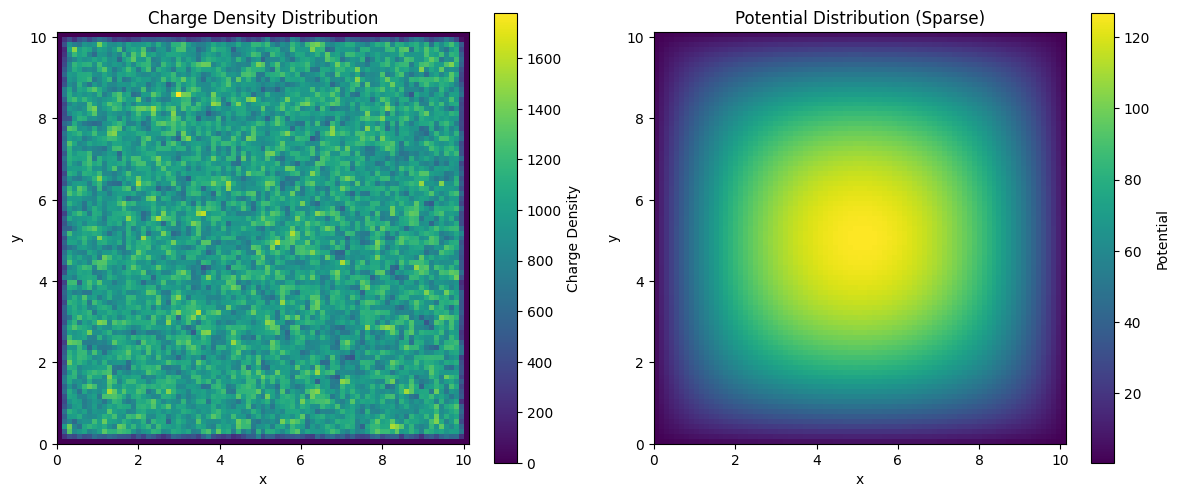

In [226]:
# Grid parameters
#dx = 0.1
#dy = 0.1
nx = int(ncell ** 0.5)+1
ny = int(ncell ** 0.5)+1
# Example charge density distribution
rho_electron = charge_density(position_x, position_y, dx, dy, length)
# Solve the Poisson equation using sparse matrix method
solution_sparse = solve_poisson_sparse(rho_electron, dx, dy)

# Plot charge density and potential
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(rho_electron, origin='lower', extent=[0, nx*dx, 0, ny*dy], cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Distribution')

plt.subplot(1, 2, 2)
plt.imshow(solution_sparse, origin='lower', extent=[0, nx*dx, 0, ny*dy], cmap='viridis')
plt.colorbar(label='Potential')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential Distribution (Sparse)')

plt.tight_layout()
plt.show()

In [227]:
' TESTS '
'''
rho_electron = charge_density(position_x, position_y, dx, dy, length)
print("RHO_ELECTRON \n", rho_electron)
print("Total charge electron : ", np.sum(rho_electron))
#rho = ghost(rho_electron)
#print('RHO GHOST\n', rho)
plt.imshow(rho_electron, origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density ELECTRON')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()


background_charge_density, background_charge_density_frame = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)
print("RHO_Background \n", background_charge_density)
plt.imshow(background_charge_density, origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density Background')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()


print("RHO_Background frame \n", background_charge_density_frame)
print("Total background charge : ", np.sum(background_charge_density))
plt.imshow(background_charge_density_frame, origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density Background frame')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()


rho_total = background_charge_density_frame + rho_electron
print("RHO total \n", rho_total)
print("Total charge system : ", np.sum(rho_total))
plt.imshow(rho_total, origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density total frame')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()




rho = ghost(rho_total)
print("RHO WITH GHOST \n", rho_total)
plt.imshow(rho, origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density total ghost')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()




potential = calculate_potential(rho, dx, dy)
print("v_ELECTRON \n", potential)
print(np.sum(potential))
plt.imshow(potential, origin='lower', cmap='viridis')
plt.colorbar(label='potential frame')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential Heatmap')
plt.show()



potential_ghost = ghost(potential)
print("v_ELECTRON \n", potential_ghost)
plt.imshow(potential_ghost, origin='lower', cmap='viridis')
plt.colorbar(label='potential ghost')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential Heatmap')
plt.show()

E_field_x, E_field_y = calculate_electric_field(potential_ghost, dx, dy)
print("E_AT_GRID:", E_field_x)
plt.imshow(E_field_x, origin='lower', cmap='viridis')
plt.colorbar(label='Electric field at grids frame')
plt.xlabel('x')
plt.ylabel('y')
plt.title('E field Heatmap')
plt.show()



"""
E_x_at_grid, E_y_at_grid, k_sq, electric_potential_grid = poisson_solver(rho_total, dx, dy)
print(" EX AT GRID : \n",E_x_at_grid)
print(np.sum(E_x_at_grid))
print(" EY AT GRID : \n",E_y_at_grid)
print(np.sum(E_y_at_grid))
print("K SQUARE : \n",k_sq)
print(np.sum(k_sq))
print(" Electric potential at grid : \n",electric_potential_grid)
print(np.sum(electric_potential_grid))

Ex_at_particle, Ey_at_particle, force_x, force_y, acc_x, acc_y = interpolate_field (position_x, position_y, dx, dy, length, E_x_at_grid, E_y_at_grid)
print(" EX AT PARTICLE : \n",Ex_at_particle)
print(np.sum(Ex_at_particle))
print(" EY AT PARTICLE : \n",Ey_at_particle)
print(np.sum(Ey_at_particle))

"""
'''

'\nrho_electron = charge_density(position_x, position_y, dx, dy, length)\nprint("RHO_ELECTRON \n", rho_electron)\nprint("Total charge electron : ", np.sum(rho_electron))\n#rho = ghost(rho_electron)\n#print(\'RHO GHOST\n\', rho)\nplt.imshow(rho_electron, origin=\'lower\', cmap=\'viridis\')\nplt.colorbar(label=\'Charge Density ELECTRON\')\nplt.xlabel(\'x\')\nplt.ylabel(\'y\')\nplt.title(\'Charge Density Heatmap\')\nplt.show()\n\n\nbackground_charge_density, background_charge_density_frame = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)\nprint("RHO_Background \n", background_charge_density)\nplt.imshow(background_charge_density, origin=\'lower\', cmap=\'viridis\')\nplt.colorbar(label=\'Charge Density Background\')\nplt.xlabel(\'x\')\nplt.ylabel(\'y\')\nplt.title(\'Charge Density Heatmap\')\nplt.show()\n\n\nprint("RHO_Background frame \n", background_charge_density_frame)\nprint("Total background charge : ", np.sum(background_charge_density))\nplt.imshow(

In [228]:
'''
for step in range(n_step):
    timesteps_list.append(iteration)
    #pos_x_list = position_x
    #print(" POSITION X COORDINATES FOR EACH ITERATIONS \n", pos_x_list)
    #vel_x_list.append(vel_x)

    ke_particle, ke_system, vel_resultant = kinetic_energy(vel_x, vel_y, particle_mass)
    ke_system_list.append(ke_system)


    rho_electron = charge_density(position_x, position_y, dx, dy, length)
    background_charge_density= calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)   #, background_charge_density_frame
    rho_total = background_charge_density + rho_electron
    #rho = ghost(rho_total)

    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)

    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)

    vx_half = vel_x + (0.5 * dt * acceleration_x)
    vy_half = vel_y + (0.5 * dt * acceleration_y)

    position_x += vx_half * dt
    position_y += vy_half * dt

    rho_electron = charge_density(position_x, position_y, dx, dy, length)
    background_charge_density = calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)    #, background_charge_density_frame
    rho_total = background_charge_density + rho_electron
    #rho = ghost(rho_total)

    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)

    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)

    vel_x = vx_half + 0.5 * dt * acceleration_x
    vel_y = vy_half + 0.5 * dt * acceleration_y

    iteration += 1
    print("ITERATION : ", iteration)



    # Plotting histogram
    #plt.hist(vel_resultant, bins=150, density=True, alpha=0.75)
    #plt.xlabel('Velocity')
    #plt.ylabel('Probability Density')
    #plt.title('Probability Distribution of Particle Velocities')
    #plt.grid(True)
    #plt.xlim([0, 1])  # Replace min_velocity and max_velocity with your desired limits
    #plt.ylim([0, 20])
    #plt.show()

    plt.imshow(E_grid_x, origin='lower', cmap='viridis')
    plt.colorbar(label='Charge Density')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Charge Density Heatmap')
    plt.show()

    t += dt
'''

'\nfor step in range(n_step):\n    timesteps_list.append(iteration)\n    #pos_x_list = position_x\n    #print(" POSITION X COORDINATES FOR EACH ITERATIONS \n", pos_x_list)\n    #vel_x_list.append(vel_x)\n\n    ke_particle, ke_system, vel_resultant = kinetic_energy(vel_x, vel_y, particle_mass)\n    ke_system_list.append(ke_system)\n\n\n    rho_electron = charge_density(position_x, position_y, dx, dy, length)\n    background_charge_density= calculate_background_charge_density(dx, dy, length, particle_charge, nparticles)   #, background_charge_density_frame\n    rho_total = background_charge_density + rho_electron\n    #rho = ghost(rho_total)\n\n    E_grid_x, E_grid_y, k_square, electric_potential_grid = poisson_solver(rho_total, dx, dy)\n\n    Ex_at_particle, Ey_at_particle, force_x, force_y, acceleration_x, acceleration_y = interpolate_field(position_x, position_y, dx, dy, length, E_grid_x, E_grid_y)\n\n    vx_half = vel_x + (0.5 * dt * acceleration_x)\n    vy_half = vel_y + (0.5 * dt *

In [229]:
'''
#print("END POSITION X COORDINATES : \n ",pos_x_list)
print("Length of timesteps_list:", len(timesteps_list))
print("Length of ke_system_list:", len(ke_system_list))
'''

'\n#print("END POSITION X COORDINATES : \n ",pos_x_list)\nprint("Length of timesteps_list:", len(timesteps_list))\nprint("Length of ke_system_list:", len(ke_system_list))\n'

In [230]:
'''
plt.plot(timesteps_list, ke_system_list, linestyle='-')
plt.title('Kinetic Energy vs Timestep')
plt.xlabel('Timestep')
plt.ylabel('Kinetic Energy')
#plt.grid(True)
plt.show()




plt.imshow(rho, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()


plt.imshow(electric_potential_grid, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='ELECTRIC POTENTIAL')
plt.xlabel('x')
plt.ylabel('y')
plt.title('ELECTRIC POTENTIAL HEAT MAP')
plt.show()

plt.imshow(k_square, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='K SQUARE')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K SQUARE HEAT MAP')
plt.show()
'''


'''
plt.imshow(rho_electron, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()

plt.imshow(background_charge_density, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()

plt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')
plt.colorbar(label='Charge Density')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Charge Density Heatmap')
plt.show()
'''

"\nplt.imshow(rho_electron, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n\nplt.imshow(background_charge_density, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n\nplt.imshow(rho_total, extent=(0, length, 0, length), origin='lower', cmap='viridis')\nplt.colorbar(label='Charge Density')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.title('Charge Density Heatmap')\nplt.show()\n"